# Snapchat Political Ads
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the reach (number of views) of an ad.
    * Predict how much was spent on an ad.
    * Predict the target group of an ad. (For example, predict the target gender.)
    * Predict the (type of) organization/advertiser behind an ad.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
This dataset reports the cost and effectivness for Snapchat political ads and implies the strategies they employ based on regions, languages etc. that they utilize. Considering the somewhat close correlation between impressions and spend within the dataset, using more of its features may help predict how much is spent per ad. This creates a regression problem, my 2nd baseline model will use the following fields:

'Currency Code', 'OrganizationName', 'CountryCode', 'BillingAddress', 'StartDate', 'Impressions','Spend over Impressions (sqrt)', 'Impressions over Spend (sqrt)'; 

and my final model will use the following fields: 
'Currency Code', 'Spend', 'Impressions', 'StartDate','EndDate','PayingAdvertiserName','OrganizationName','Postal Codes (Included)','Postal Codes (Excluded)','CreativeProperties', 'Spend over Impressions (sqrt)', 'Impressions over Spend (sqrt)'

The evalutation metric will be R^2. Considering how this is a regression problem, accuracy will be the prime objective and fairness will be evaluated through R^2 consistency across USD and non-USD bought ads. 

### Baseline Model
In order to make a better prediction, the initial features, i.e. 'Currency Code', 'BillingAddress','StartDate','Impressions', 'Spend' were used. StartDate was converted to just the Ordinal value 'months', BillingAddress and Currency Code were converted to Ordinal values. Impressions and Spend remained as quantative fields. 

The average R^2 for the initial baseline model was 0.617294. This score seemed good for the intial model, however, without the impressions field this score would be dramatically smaller so improving from here was difficult as other features didn't play a role as important as impressions.

The average R^2 for the second baseline model was 0.64 after including 'OrganizationName' and 'CountryCode' in the regression and adding two new features. Taking the square root of Spend over Impressions and Impressions over spend and setting them as new features helped increase R^2 by about .01. The score is still decent, however improvement from adding two new fields encoded as ordinal proved to have only a small effect on the resulting score. Columns such as the OrdinalEncoded CreativeProperties helped improve accuracy by a very small margin (about a .002 R^2 increase).

Ordinal: 7
quantitative: 1

### Final Model
After seeing that impressions plays the most significant role in predicting spend, using other features proved to only increase R^2 at a snails pace. In an effort to increase accuracy, I figured that adding fields such as 'PayingAdvertiserName', 'Postal Codes (Included)', 'Postal Codes (Excluded)', 'CreativeProperties', 'EndDate' will be helpful. Postal codes could lower or increase cost based on whether their excluded or not. Certain PayingAdvertiserName values can be assocaited with certain levels of spend since these are 'the names of entities providing the funds'. If an ad has a long duration, i.e. big (EndDate - StartDate) value, then the ad may be more expensive. CreativeProperties can possibly influence spend by having it vary based on its call to action.  

To choose the best regression function, the functions: KNeighborsRegressor, DecisionTreeRegressor, LinearRegression, BayesianRidge, RandomForestRegressor, PLSRegression were looped through and their min, max, and average R^2 were recorded in a DataFrame after being used in the model 100 times each. The function with the best average R^2 (RandomForestRegressor) was chosen as the best function, RandomForestRegressor had an average R^2 of 0.702869.
These factors amounted to the final model that was implemented as a ML-pipeline using RandomForestRegressor.



### Fairness Evaluation

Null: R^2 is about the same for USD and non-USD

Alt: R^2 is not the same for USD and non-USD

Significance Level: .05

As a way to evaluate fairness, a permutation test was run to see whether the model is more accurate for ads that are bought via USD rather than another currency. The significance level was set to .05 and 100 simulations were run, the absolute difference between the R^2 of USD and R^2 of non-USD was used as the statistic. The p_value, being 0.36, resulted in the null hypothesis not being rejected, and supported the pipeline as a fair model between USD and non-USD ads.


# Code

In [2045]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures


In [2046]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression

regression_funcs = [KNeighborsRegressor, DecisionTreeRegressor, LinearRegression, BayesianRidge, RandomForestRegressor, PLSRegression]



In [2047]:
#Cleaning the data (Code from Project3)

pd.set_option('display.max_columns', None)

fp_18 = os.path.join('political_data', 'PoliticalAds_2018.csv')
df_18 = pd.read_csv(fp_18)

fp_19 = os.path.join('political_data', 'PoliticalAds_2019.csv')
df_19 = pd.read_csv(fp_19)

political_data = pd.concat([df_18, df_19], ignore_index=True) # Concat both CSVs

# Convert dates to datetime and same time zone
political_data['StartDate'] = pd.to_datetime(political_data['StartDate']
                                            ).dt.tz_convert(tz = 'UTC')
political_data['EndDate'] = pd.to_datetime(political_data['EndDate']
                                          ).dt.tz_convert(tz = 'UTC')


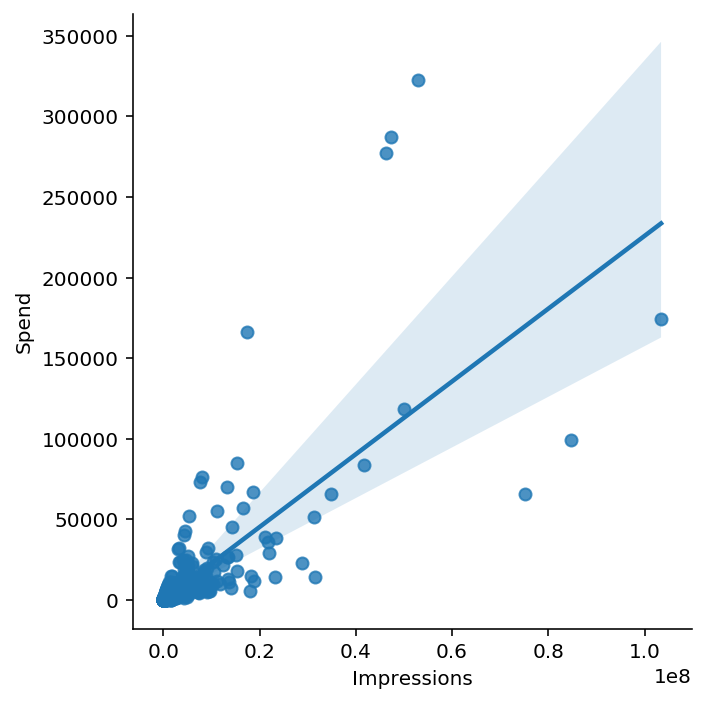

In [2048]:
#Impressions alone does not seem to be the best predictor for spend

curr_data = political_data.loc[
    political_data['Impressions'] < political_data['Impressions'].max()
    ]
sns.lmplot(
    
    data = curr_data, 
    x =  'Impressions', 
    y = 'Spend', 
    #title = 'Spend vs Impressions LM Plot'
    
    )

### Baseline Model

In [2021]:
def rmse(original, preds):
    """
    Finds the Root-Mean-Squared Error of two given
    Arrays/Series
    """
    return np.sqrt(np.mean((original - preds)**2))


In [2049]:
#Making features

encoded_data = political_data.copy()

encoded_data['Currency Code'] = OrdinalEncoder().fit_transform(
    political_data[['Currency Code']] #Ordinal Encoded Currency Code
    )
encoded_data['BillingAddress'] = OrdinalEncoder().fit_transform(
    political_data[['BillingAddress']] #Ordinal Encoded BillingAddress
    )

encoded_data['StartDate'] = pd.DatetimeIndex(
    political_data['StartDate']
    ).month
    # Extracted months from StartDate
    

In [2022]:
#Get fields with no missing values that can be numerically encoded

data = encoded_data[
    ['Currency Code', 
     'BillingAddress',
     'StartDate',
     'Impressions', 
     'Spend']
    ]

data.head(5)


,Currency Code,BillingAddress,StartDate,Impressions,Spend
0,2.0,146.0,9,339296,447
1,4.0,58.0,8,36514,116
2,2.0,181.0,8,521729,923
3,4.0,45.0,8,203723,853
4,4.0,35.0,10,325243,518


In [2023]:
lr = LinearRegression() 
#Chosen Fregression function to start with

X = data.drop('Spend', axis = 1)
y = data['Spend']

scores = []
for i in range(500):
    # Uses the function 500 times to get an
    # average R^2
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #Split the data for training and testing
    
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    score = lr.score(X_test, y_test)
    scores.append(score)
    #Append score to scores to later find the avg
    
print(f"Average Score: {np.mean(scores)}")


Average Score: 0.6172941835590162


In [2050]:
# Two new features that may be relevent to Spend

encoded_data['OrganizationName'] = OrdinalEncoder().fit_transform(
    political_data[['OrganizationName']]
    # Ordinal encoded OrganizationName
    )
encoded_data['CountryCode'] = OrdinalEncoder().fit_transform(
    political_data[['CountryCode']]
    # Ordinal encoded CountryCode
    )

encoded_data['Spend over Impressions (sqrt)'] = (
    political_data['Impressions']/political_data['Spend'].replace(0, 1)
    ).apply(np.sqrt)
encoded_data['Impressions over Spend (sqrt)'] = (
    political_data['Spend'].replace(0, 1)/political_data['Impressions']
    ).apply(np.sqrt)


In [2053]:
#DataFrame with the two new features

data = encoded_data[
    ['Currency Code', 
     'OrganizationName', 
     'CountryCode',
     'BillingAddress',
     'StartDate', 
     'Impressions', 
     'Spend',
     'Spend over Impressions (sqrt)',
     'Impressions over Spend (sqrt)',]
    ]

data.head(5)


,Currency Code,OrganizationName,CountryCode,BillingAddress,StartDate,Impressions,Spend,Spend over Impressions (sqrt),Impressions over Spend (sqrt)
0,2.0,160.0,16.0,146.0,9,339296,447,27.550888,0.036296
1,4.0,238.0,28.0,58.0,8,36514,116,17.741924,0.056364
2,2.0,274.0,7.0,181.0,8,521729,923,23.775061,0.042061
3,4.0,183.0,28.0,45.0,8,203723,853,15.454164,0.064707
4,4.0,62.0,28.0,35.0,10,325243,518,25.057578,0.039908


In [2054]:
lr = LinearRegression()
X = data.drop('Spend', axis = 1)
y = data['Spend']

new_scores = []
for i in range(500):
    # Uses the function 500 times to get an
    # average R^2
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #Split the data for training and testing
    
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    score = lr.score(X_test, y_test)
    new_scores.append(score)
    #Append score to scores to later find the avg
    
print(f"Average Score: {np.mean(new_scores)}")


Average Score: 0.6408606149205898


In [2056]:
print(f"Amount of Improvement (Score): {np.mean(new_scores) - np.mean(scores)}")


Amount of Improvement (Score): 0.17582236184360994


### Final Model

In [2061]:

    
#A number is mapped to each unique value in 
#Currency Code, PayingAdvertiserName, OrganizationName,
#so that the pipeline can process any new value used
    
keys = political_data['Currency Code'].unique()
values = pd.DataFrame(OrdinalEncoder().fit_transform(pd.DataFrame(keys)))[0]
currency_code_map = dict(zip(keys, values))
    
keys = political_data['PayingAdvertiserName'].unique()
values = pd.DataFrame(OrdinalEncoder().fit_transform(pd.DataFrame(keys)))[0]
pa_code_map = dict(zip(keys, values))
    
keys = political_data['OrganizationName'].unique()
values = pd.DataFrame(OrdinalEncoder().fit_transform(pd.DataFrame(keys)))[0]
on_code_map = dict(zip(keys, values))
    
    
################ Replaces values with numbers assinged in the mapping #############
    
def map_currency_code(input):
    return input.replace({'Currency Code': currency_code_map})[['Currency Code']]
    
def map_pa_code(input):
    return input.replace({'PayingAdvertiserName': pa_code_map})[['PayingAdvertiserName']]
    
def map_on_code(input):
    return input.replace({'OrganizationName': on_code_map})[['OrganizationName']]
    
    
###############################################################################
    
def get_days(input):
    """
    Finds the number of days between StartDate and EndDate, if EndDate is null
    there is only -1, meaning that the ad is ongoing
    """
    return pd.DataFrame(
        (input['EndDate'] - input['StartDate']
        ).apply(lambda x: x.days).fillna(-1))
    
def fix_post(input):
    """
    Encodes postal codes with ordinal values
    """
    return OrdinalEncoder().fit_transform(input.fillna('nan'))
    
def creative_prop_fix(input):
    """
    Extracts the domain from the url and encodes them with
    ordinal values
    """
    #print(input)
    return OrdinalEncoder().fit_transform(pd.DataFrame(
        input['CreativeProperties'].str.split('?').str[0].str.replace(
            'web_view_url:', '').fillna('nan')))
    


In [2062]:
def get_pipe(func):
    """
    Uses the provided regression function (func) and fields within the
    snapchat political ads dataset to predict spend for an ad
    """
    extract_start_month = Pipeline([
        #Pipeline for days between StartDate & EndDate

        ('get_start_month', FunctionTransformer(get_days))
    ])

    
    fix_currency_code = Pipeline([
        #Pipeline for maping currency code
        
        ('fix_currcode', FunctionTransformer(map_currency_code))
    ])
    
    
    fix_pa_code = Pipeline([
        #Pipeline for mapping paying advertiser name
        
        ('fix_pa', FunctionTransformer(map_pa_code))
    ])
    
    fix_on_code = Pipeline([
        #Pipeline for maping organization name
        
        ('fix_on', FunctionTransformer(map_on_code))
    ])
    
    
    fix_postal_code = Pipeline([
        #Pipeline for encoding postal codes with ordinal values
        
        ('fix_post', FunctionTransformer(fix_post))
    ])
    
    fix_creative_prop = Pipeline([
        #Pipeline for encoding creative property domains 
        #with ordinal values
        
        ('fix_cp', FunctionTransformer(creative_prop_fix))
    ])
    
    
    preprocess = ColumnTransformer([
        #Transforms the columns using the above pipelines
        
        ('get_start_month', extract_start_month, ['StartDate', 'EndDate']),
        ('fix_currency_code', fix_currency_code, ['Currency Code']),
        ('fix_pa', fix_pa_code, ['PayingAdvertiserName']),
        ('fix_on', fix_on_code, ['OrganizationName']),
        ('fix_post', fix_postal_code, ['Postal Codes (Included)', 'Postal Codes (Excluded)']),
        ('fix_cp', fix_creative_prop, ['CreativeProperties']),
        
    ], remainder = 'passthrough')
    
    return Pipeline([('preprocess', preprocess), ('regression_func', func())])



In [2063]:
pd.options.mode.chained_assignment = None

test = political_data[[
    #Fields used within the pipeline to
    #predict spend
    
    'Currency Code', 
    'Spend', 
    'Impressions', 
    'StartDate',
    'EndDate',
    'PayingAdvertiserName',
    'OrganizationName',
    'Postal Codes (Included)',
    'Postal Codes (Excluded)',
    'CreativeProperties',
    
    ]]


#Creating the following columns has improved R^2 by about .01 
test['Spend over Impressions (sqrt)'] = (
    test['Impressions']/test['Spend'].replace(0, 1)
    ).apply(np.sqrt)
test['Impressions over Spend (sqrt)'] = (
    test['Spend'].replace(0, 1)/test['Impressions']
    ).apply(np.sqrt)



In [2064]:
pipe = get_pipe(RandomForestRegressor)
#Using RandomForestRegressor as the regression
#function because it appears to yield the best
#R^2 compared to other functions

X = test.drop('Spend', axis = 1)
y = test['Spend']

score_lst = []
for i in range(1000):
    #Uses 1000 loops to find the average R^2 of the model
    #When using RandomForestRegressor
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    pipe = pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    score_lst.append(score)
    
print(f"Average Score: {np.mean(score_lst)}")


Average Score: 0.7223795636478271


In [2034]:
test = political_data[[
    #Fields used within the pipeline to
    #predict spend
    
    'Currency Code', 
    'Spend', 
    'Impressions', 
    'StartDate',
    'EndDate',
    'PayingAdvertiserName',
    'OrganizationName',
    'Postal Codes (Included)',
    'Postal Codes (Excluded)',
    'CreativeProperties',
    
    ]]

#Extra columns to improve accuracy
test['Spend over Impressions (sqrt)'] = (
    test['Impressions']/test['Spend'].replace(0, 1)
    ).apply(np.sqrt)
test['Impressions over Spend (sqrt)'] = (
    test['Spend'].replace(0, 1)/test['Impressions']
    ).apply(np.sqrt)


test['Spend'] = test['Spend'].replace(0, 1)

X = test.drop('Spend', axis = 1)
y = test['Spend']

regression_funcs = [
    #regression functions to test
    KNeighborsRegressor, 
    DecisionTreeRegressor, 
    LinearRegression, 
    BayesianRidge, 
    RandomForestRegressor, 
    PLSRegression,
]

regression_strings = strs = [
    #Strings of the function names for
    #the dataframe
    'KNeighborsRegressor', 
    'DecisionTreeRegressor', 
    'LinearRegression', 
    'BayesianRidge', 
    'RandomForestRegressor',
    'PLSRegression',
]



In [ ]:
results_df = pd.DataFrame()
mins = [] #The min R^2 for each function
maxs = [] #The max R^2 for each function
avgs = [] #The average R^2 for each function
for func in enumerate(regression_funcs):
    #Iterates through the functions to estimate which
    #has the best average R^2
    
    index = func[0]
    func = func[1]
    pipe = get_pipe(func)
    scores = []
    for i in range(100):
        #For each function, 100 loops are run to 
        #estimate which function has the best 
        #average R^2
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        pipe = pipe.fit(X_train, y_train)
        score = pipe.score(X_test, y_test)
        scores.append(score)
    
    mins.append(np.min(scores))
    maxs.append(np.max(scores))
    avgs.append(np.mean(scores))
    
results_df['Regression Function'] = regression_strings
results_df['Max R^2'] = maxs
results_df['Min R^2'] = mins
results_df['Average R^2'] = avgs


In [2035]:
results_df


,Regression Function,Max R^2,Min R^2,Average R^2
0,KNeighborsRegressor,0.789167,-0.364224,0.543374
1,DecisionTreeRegressor,0.985817,-3.155541,0.369883
2,LinearRegression,0.895463,0.352181,0.641824
3,BayesianRidge,0.937070,0.314420,0.617756
4,RandomForestRegressor,0.987319,-0.441985,0.702869
5,PLSRegression,0.890142,0.239175,0.614319


In [2042]:
#RandomForestRegressor seems to be the best function to use

best = results_df.loc[results_df['Average R^2'] == results_df['Average R^2'].max()]['Regression Function'].tolist()[0]
print(f"Best Function: {best}")


Best Function: RandomForestRegressor


In [2041]:
#Final Model

final_model = get_pipe(RandomForestRegressor)


### Fairness Evaluation

In [2037]:
#Null: R^2 is about the same for USD and non-USD
#Alt: R^2 is not the same for USD and non-USD
#Significance Level: .05

#Ads that are bought with USD
usd_obs_test = test.loc[test['Currency Code'] == 'USD']

#Ads that are not bought with USD
non_usd_obs_test = test.loc[test['Currency Code'] != 'USD']

X = usd_obs_test.drop('Spend', axis = 1)
y = usd_obs_test['Spend']

#Using RandomForestRegressor because it has the highest
#average R^2 compared to the other functions found
pipe = get_pipe(RandomForestRegressor)
pipe = pipe.fit(X, y)

#R^2 for ads that used USD
usd_score = pipe.score(X, y)

X = non_usd_obs_test.drop('Spend', axis = 1)
y = non_usd_obs_test['Spend']


pipe = get_pipe(func)
pipe = pipe.fit(X, y)

#R^2 for ads that didn't use USD
non_usd_score = pipe.score(X, y)

#The statistic: absolute difference between
#the scores
obs = abs(usd_score - non_usd_score)

print(f'USD Score: {usd_score}')
print(f'Non USD Score: {non_usd_score}')
print(f'Observed: {obs}')


USD Score: 0.9645074442762085
Non USD Score: 0.6247783335739481
Observed: 0.3397291107022604


In [2038]:
#Permutation Test

scores = []
simulations = 100
for i in range(simulations):
    #For every simulation, test the model with only USD bought ads and
    #non-USD bought ads, and see if their accuracy is fairly decided 
    #for each through a p_value
    
    perm_test = test.copy()
    
    #Shuffle currency code
    perm_test['Currency Code'] = test['Currency Code'].sample(
        frac=1, 
        replace=False
        ).reset_index(drop=True)
    
    #Get a USD and non-USD dataset
    usd_perm_test = perm_test.loc[perm_test['Currency Code'] == 'USD']
    non_usd_perm_test = perm_test.loc[perm_test['Currency Code'] != 'USD']
    
    X_usd = usd_perm_test.drop('Spend', axis = 1)
    y_usd = usd_perm_test['Spend']
    
    X_train, X_test, y_train, y_test = train_test_split(X_usd, y_usd, test_size=0.3)
    
    pipe = get_pipe(func)
    pipe = pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    
    USD_score = score #Accuracy Score for USD
    
    X_non_usd = non_usd_perm_test.drop('Spend', axis = 1)
    y_non_usd = non_usd_perm_test['Spend']
    
    X_train, X_test, y_train, y_test = train_test_split(X_non_usd, y_non_usd, test_size=0.3)
    
    pipe = get_pipe(func)
    pipe = pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    
    non_USD_score = score #Accuracy Score for non-USD
    
    scores.append(abs(USD_score - non_USD_score))
    

In [2039]:
#High p_value indicates that the null hypothesis can't
#be rejected

p_value = np.count_nonzero(scores >= obs)/simulations
print(f'p_value: {p_value}')


p_value: 0.36


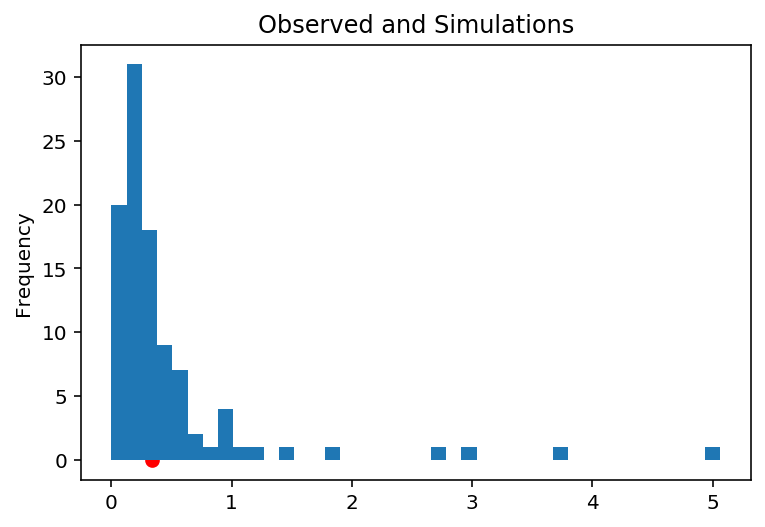

In [2040]:
#Simulated differences between USD and non-USD R^2 scores 
#indicate that both are fairly interpreted by the model

plt.scatter(obs, 0, color='red', s=40)
pd.Series(scores).plot(kind='hist', bins = 40, title = 'Observed and Simulations')
